# **3. Go Abdul-Mageed & Ungar (2017) - WASSA Emotion Intensity Dataset**

In [1]:
# Imports & Upload
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import files
import glob
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
#  Upload Files
print(" Please upload all your .txt dataset files (train/dev/test for all emotions)")
uploaded = files.upload()

 Please upload all your .txt dataset files (train/dev/test for all emotions)


Saving anger-ratings-0to1.dev.gold.txt to anger-ratings-0to1.dev.gold.txt
Saving anger-ratings-0to1.test.target.txt to anger-ratings-0to1.test.target.txt
Saving anger-ratings-0to1.train.txt to anger-ratings-0to1.train.txt
Saving fear-ratings-0to1.dev.gold.txt to fear-ratings-0to1.dev.gold.txt
Saving fear-ratings-0to1.test.gold.txt to fear-ratings-0to1.test.gold.txt
Saving fear-ratings-0to1.train.txt to fear-ratings-0to1.train.txt
Saving joy-ratings-0to1.dev.gold.txt to joy-ratings-0to1.dev.gold.txt
Saving joy-ratings-0to1.test.gold.txt to joy-ratings-0to1.test.gold.txt
Saving joy-ratings-0to1.train.txt to joy-ratings-0to1.train.txt
Saving sadness-ratings-0to1.dev.gold.txt to sadness-ratings-0to1.dev.gold.txt
Saving sadness-ratings-0to1.test.gold.txt to sadness-ratings-0to1.test.gold.txt
Saving sadness-ratings-0to1.train.txt to sadness-ratings-0to1.train.txt


In [3]:
def load_local_emotion_dataset_final():
    all_dfs = []
    for filepath in glob.glob("*.txt"):
        parts = filepath.split('-')
        emotion = parts[0]
        split = parts[-1].split('.')[0]
        if 'test.gold' in filepath:
            split = 'test'


        df = pd.read_csv(filepath, sep='\t', engine='python', quoting=3, header=None, on_bad_lines='skip')

        # Convert last column to numeric (intensity)
        intensity_col = df.columns[-1]
        df[intensity_col] = pd.to_numeric(df[intensity_col], errors='coerce')
        df = df.dropna(subset=[intensity_col])  # drop rows where intensity is invalid
        df = df.reset_index(drop=True)

        tweet_cols = df.columns[:-1]
        df['tweet'] = df[tweet_cols].apply(lambda row: ' '.join(row.astype(str)), axis=1)

        df['id'] = df.index

        # Keep only id, tweet, intensity
        df = df[['id', 'tweet', intensity_col]].copy()
        df = df.rename(columns={intensity_col: 'intensity'})

        df['emotion'] = emotion
        df['split'] = split
        all_dfs.append(df)

    return pd.concat(all_dfs, ignore_index=True)

df = load_local_emotion_dataset_final()

df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce')
df.dropna(subset=['intensity', 'tweet'], inplace=True)
df['tweet'] = df['tweet'].astype(str)

print(df.head())
print(df[['intensity']].describe())

   id                                              tweet  intensity  emotion  \
0   0  40860 My 2 teens sons just left in the car to ...      0.667  sadness   
1   1  40861 My 2 teens sons just left in the car to ...      0.458  sadness   
2   2  40862 HartRamsey'sUPLIFT If you're still disco...      0.396  sadness   
3   3  40863 @AmontanaW I nearly dropped my phone int...      0.271  sadness   
4   4  40864 Whenever I'm feeling sad I will listen t...      0.604  sadness   

  split  
0  test  
1  test  
2  test  
3  test  
4  test  
         intensity
count  6342.000000
mean      0.499044
std       0.196371
min       0.000000
25%       0.354000
50%       0.482500
75%       0.646000
max       1.000000


In [4]:
# Cleaning
df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce')
df.dropna(subset=['intensity', 'tweet'], inplace=True)
df['tweet'] = df['tweet'].astype(str)

print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 id           0
tweet        0
intensity    0
emotion      0
split        0
dtype: int64


In [5]:
# Text Preprocessing
def preprocess(text_series):
    text_series = text_series.str.lower()
    text_series = text_series.str.replace("(<br/>)", "", regex=True)
    text_series = text_series.str.replace('(<a).*(>).*(</a>)', '', regex=True)
    text_series = text_series.str.replace('(&amp)', '&', regex=True)
    text_series = text_series.str.replace('(&gt)', '>', regex=True)
    text_series = text_series.str.replace('(&lt)', '<', regex=True)
    text_series = text_series.str.replace('(\xa0)', ' ', regex=True)
    text_series = text_series.str.replace(r"http\S+|www.\S+", "", regex=True)  # URLs
    text_series = text_series.str.replace(r"@\w+", "", regex=True)  # Mentions
    text_series = text_series.str.replace(r"#", "", regex=True)  # Hashtags
    text_series = text_series.str.replace(r"[^\w\s]", "", regex=True)  # Remove punctuation
    text_series = text_series.str.strip()
    return text_series

df['tweet'] = preprocess(df['tweet'])

In [6]:
# Feature Engineering
df['polarity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['tweet'].apply(lambda x: len(str(x)))

In [7]:
# Quick Stats
print("\n Descriptive Statistics:")
print(df[['intensity', 'polarity', 'subjectivity', 'word_count', 'char_count']].describe())


 Descriptive Statistics:
         intensity     polarity  subjectivity   word_count   char_count
count  6342.000000  6342.000000   6342.000000  6342.000000  6342.000000
mean      0.499044     0.036126      0.428685    17.155944    95.117629
std       0.196371     0.448142      0.290457     6.598504    34.663144
min       0.000000    -1.000000      0.000000     3.000000    15.000000
25%       0.354000    -0.250000      0.200000    12.000000    66.000000
50%       0.482500     0.000000      0.425000    18.000000    99.000000
75%       0.646000     0.375000      0.600000    23.000000   126.000000
max       1.000000     1.000000      1.000000    34.000000   154.000000


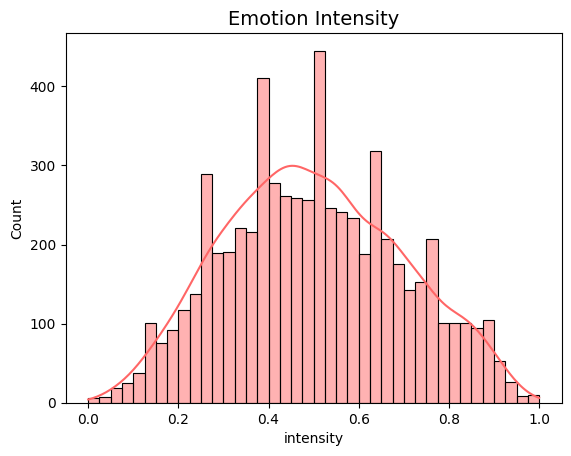

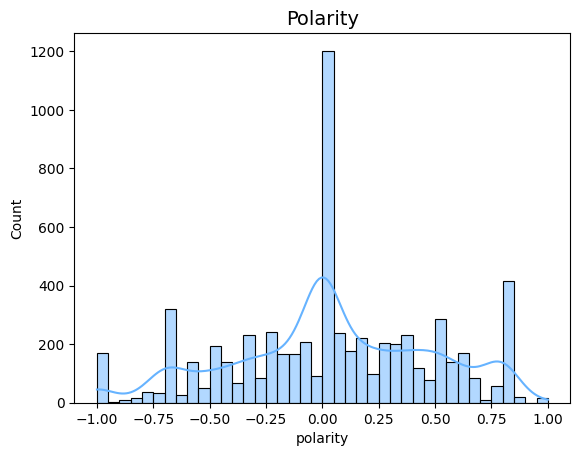

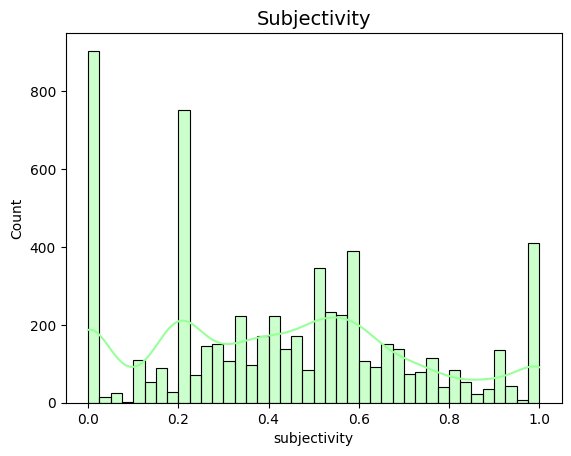

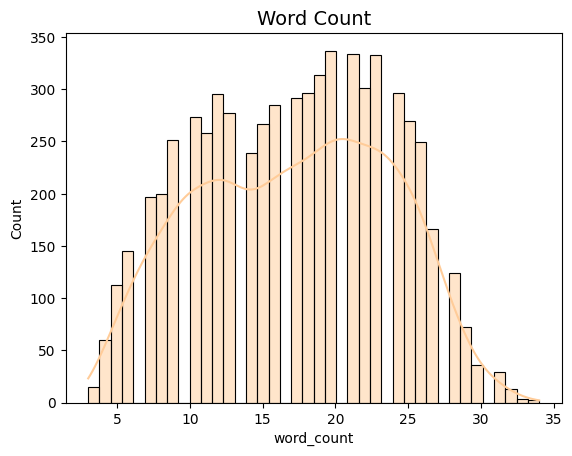

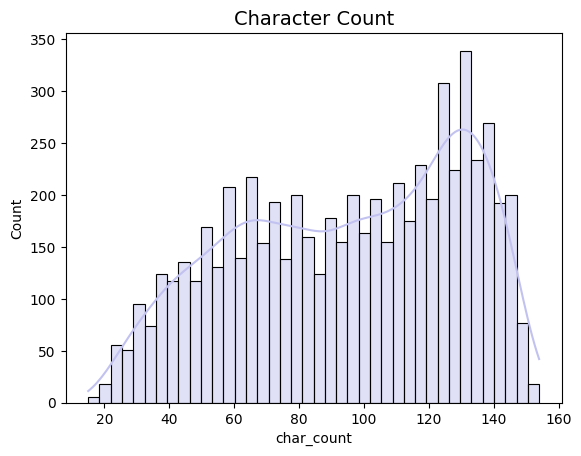

In [8]:
# Distributions
features = ['intensity', 'polarity', 'subjectivity', 'word_count', 'char_count']
titles = ['Emotion Intensity', 'Polarity', 'Subjectivity', 'Word Count', 'Character Count']
colors = ['#ff6666', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

for feature, title, color in zip(features, titles, colors):
    sns.histplot(df[feature], bins=40, color=color, kde=True)
    plt.title(title, fontsize=14)
    plt.show()

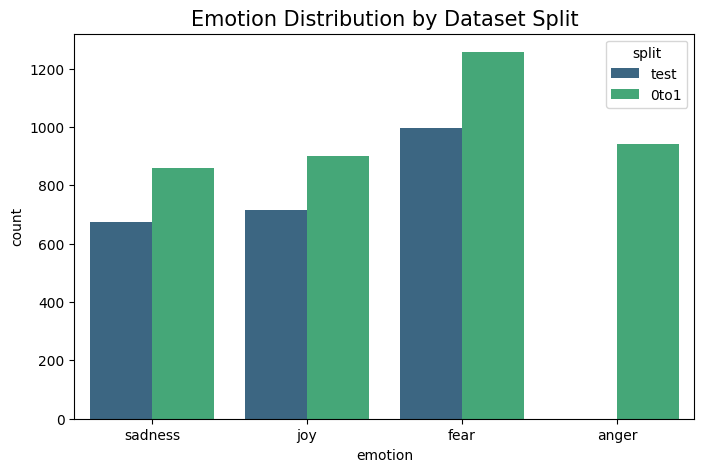

In [9]:
# Emotion & Split Counts
plt.figure(figsize=(8,5))
sns.countplot(x='emotion', hue='split', data=df, palette='viridis')
plt.title('Emotion Distribution by Dataset Split', fontsize=15)
plt.show()

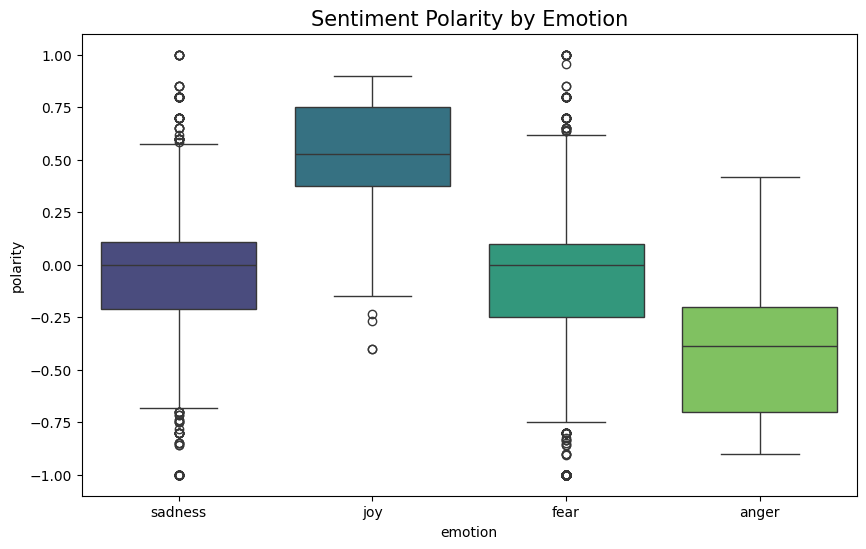

In [10]:
# Polarity by Emotion
plt.figure(figsize=(10,6))
sns.boxplot(x='emotion', y='polarity', data=df, palette='viridis')
plt.title('Sentiment Polarity by Emotion', size=15)
plt.show()

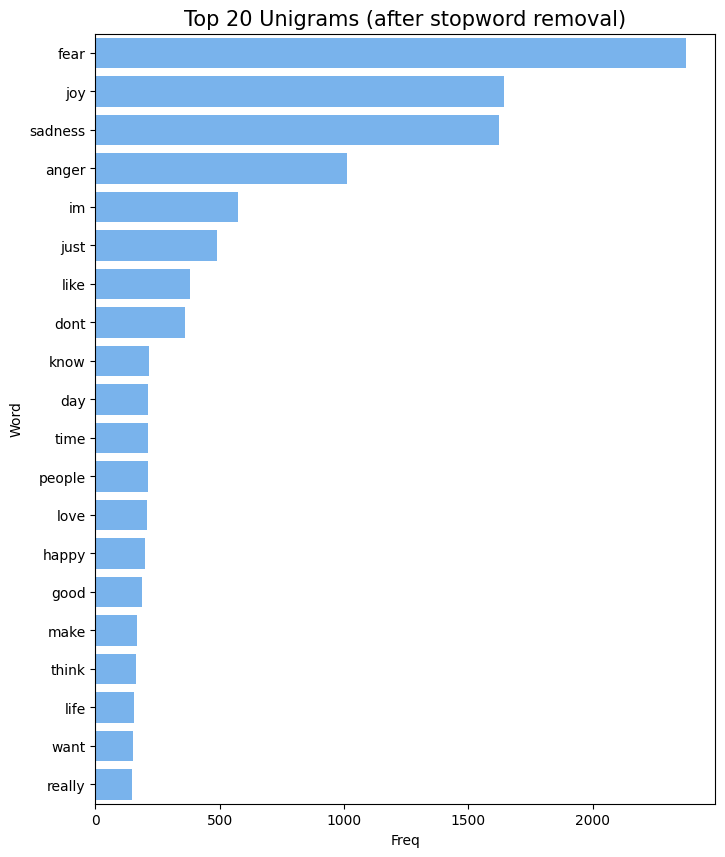

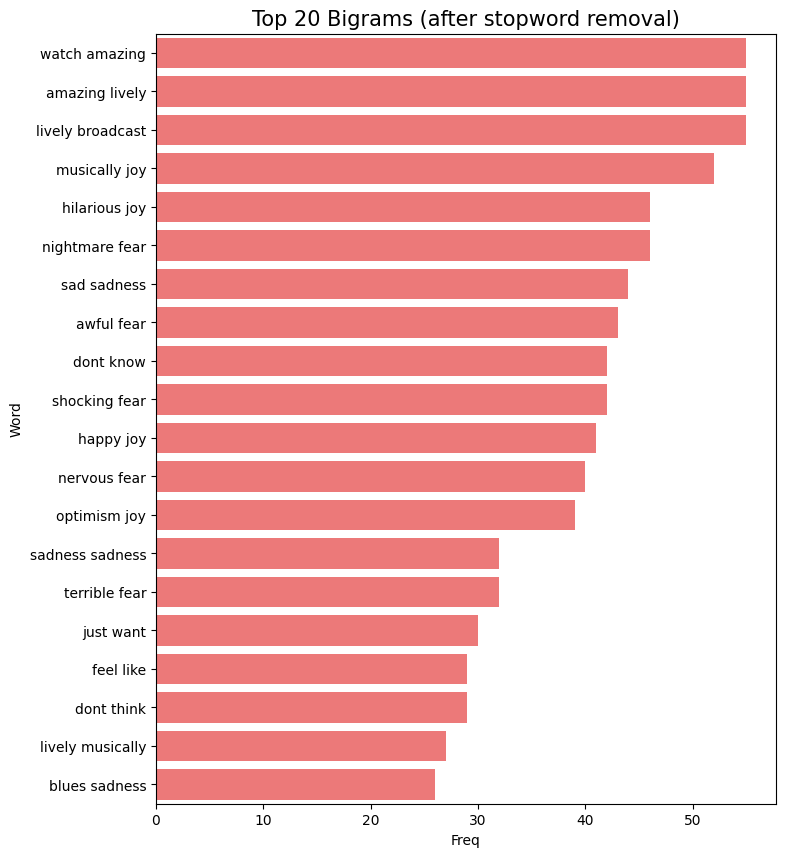

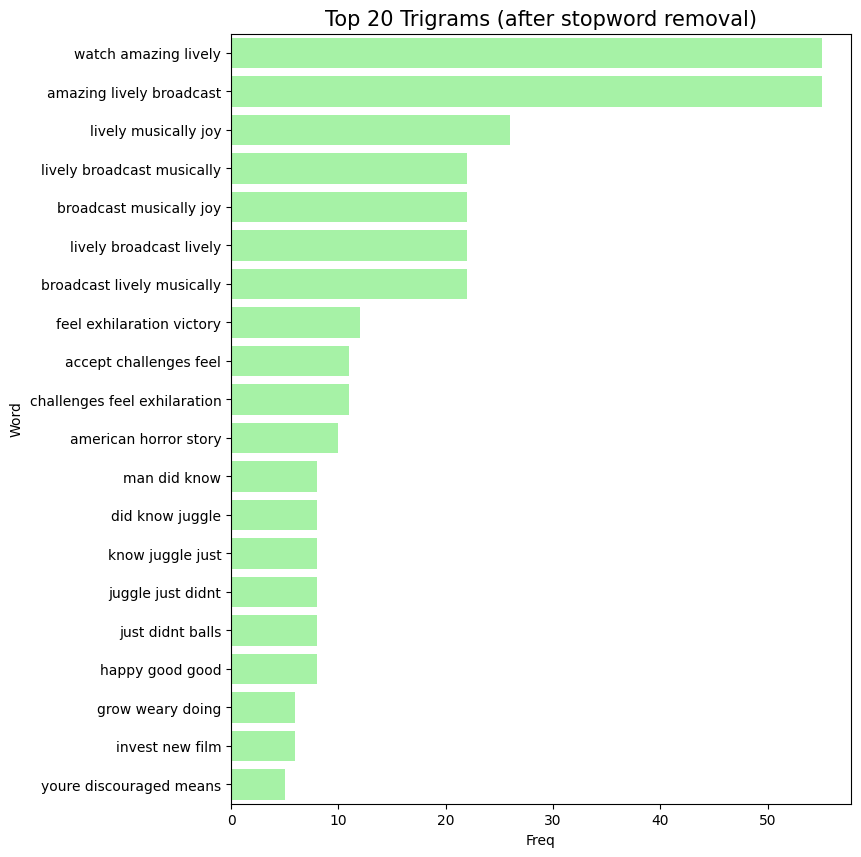

In [11]:
# Word Frequency (N-grams)
def get_top_ngrams(corpus, ngram_range=(1,1), stop_words='english', n=20):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    df_words = pd.DataFrame(words_freq[:n], columns=['Word', 'Freq'])
    return df_words

stop_words = 'english'
n = 20
unigrams = get_top_ngrams(df['tweet'], (1, 1), stop_words, n)
bigrams = get_top_ngrams(df['tweet'], (2, 2), stop_words, n)
trigrams = get_top_ngrams(df['tweet'], (3, 3), stop_words, n)

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', data=unigrams, color='#66b3ff')
plt.title('Top 20 Unigrams (after stopword removal)', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', data=bigrams, color='#ff6666')
plt.title('Top 20 Bigrams (after stopword removal)', size=15)
plt.show()

plt.figure(figsize=(8, 10))
sns.barplot(x='Freq', y='Word', data=trigrams, color='#99ff99')
plt.title('Top 20 Trigrams (after stopword removal)', size=15)
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


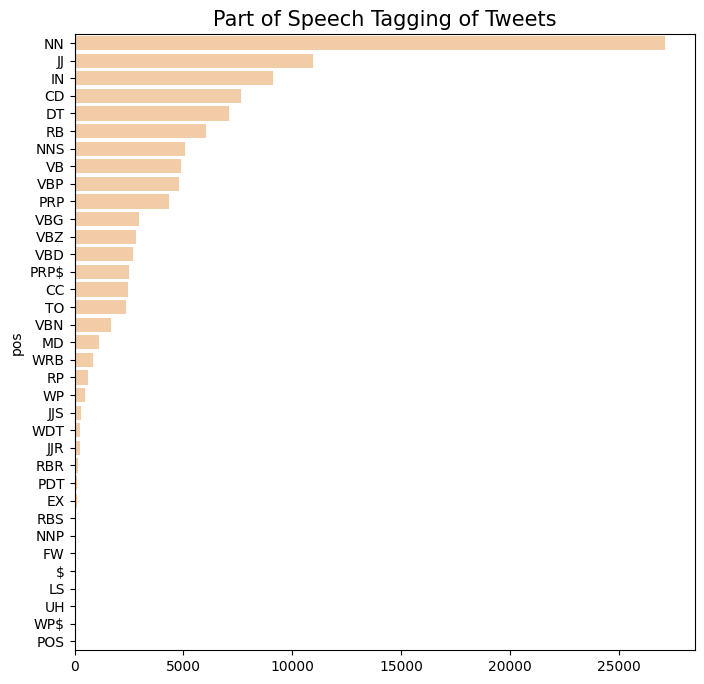

In [12]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

all_tags = []
for tweet in df['tweet']:
    if tweet.strip():
        tokens = nltk.word_tokenize(tweet)
        tags = nltk.pos_tag(tokens)
        all_tags.extend(tags)

import pandas as pd
pos_df = pd.DataFrame(all_tags, columns=['word', 'pos'])
top_pos = pos_df['pos'].value_counts()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.barplot(y=top_pos.index, x=top_pos.values, color='#ffcc99')
plt.title('Part of Speech Tagging of Tweets', size=15)
plt.show()


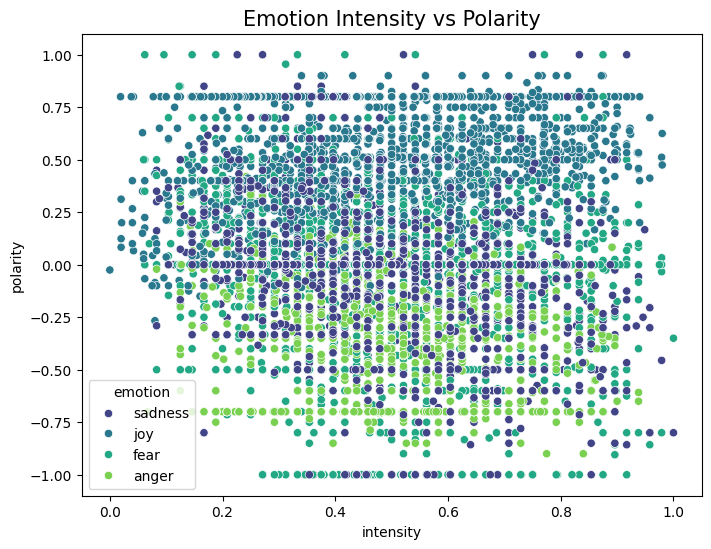

In [13]:
#  Intensity vs Polarity
plt.figure(figsize=(8, 6))
sns.scatterplot(x='intensity', y='polarity', hue='emotion', data=df, palette='viridis')
plt.title('Emotion Intensity vs Polarity', size=15)
plt.show()

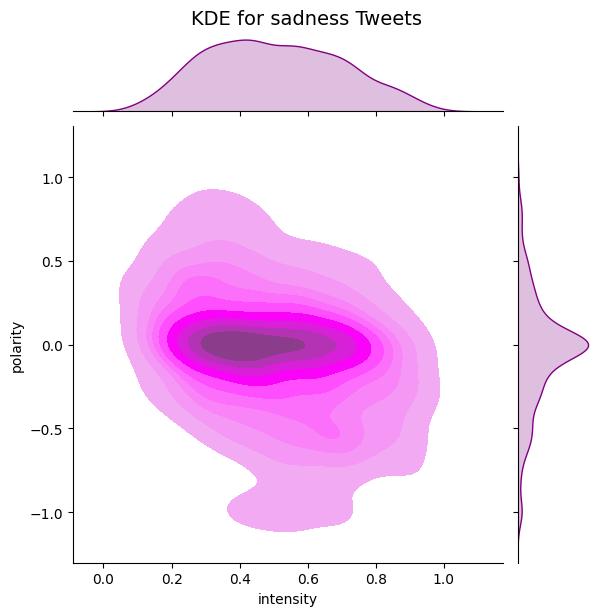

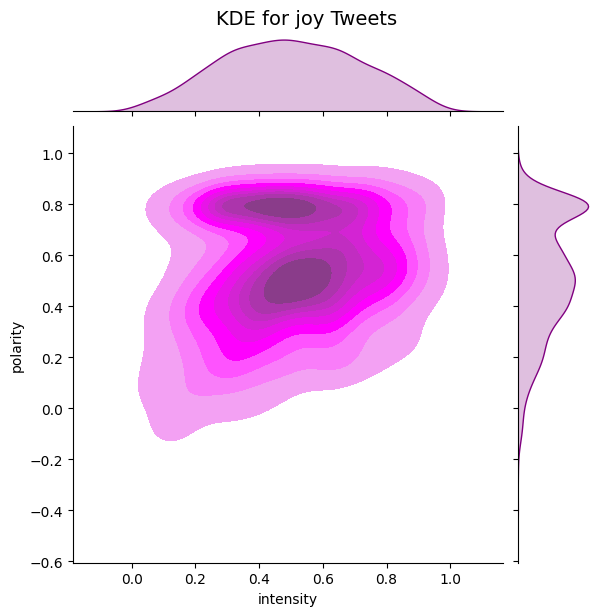

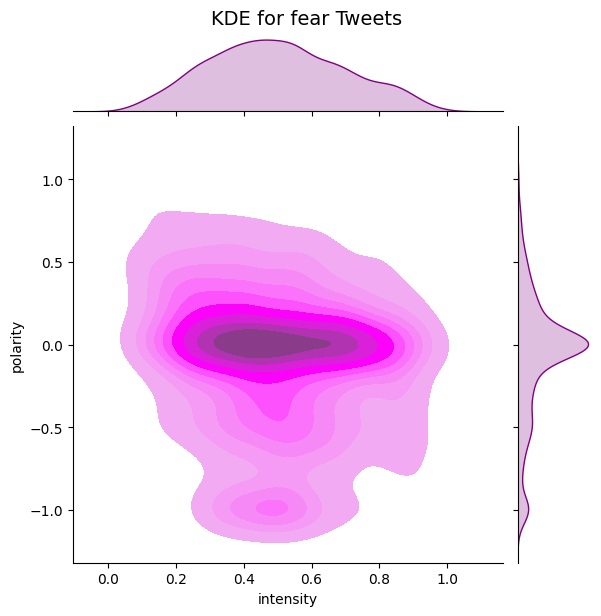

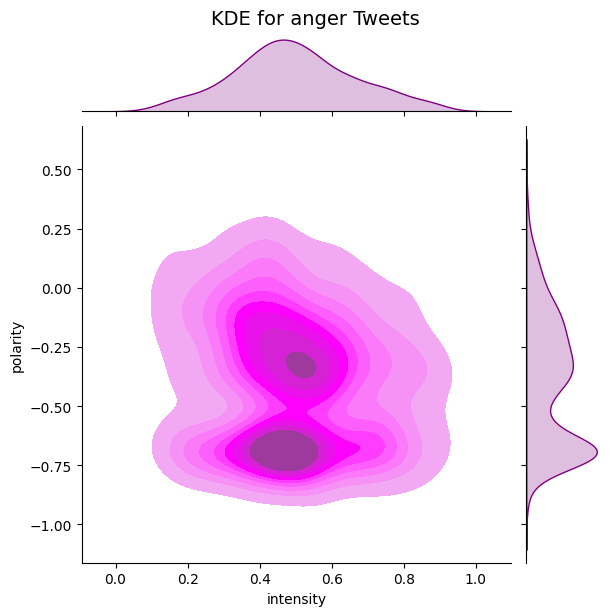

In [14]:
# KDE Plots per Emotion
for emo in df['emotion'].unique():
  subset = df[df['emotion'] == emo]
  g = sns.jointplot(x='intensity', y='polarity', data=subset, kind='kde', fill=True, color='purple')
  plt.suptitle(f'KDE for {emo} Tweets', y=1.02, size=14)
  plt.show()